In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
import emcee
import scipy.stats
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [2]:
data= np.load('transient.npy')

First, always start with a quick look at the data

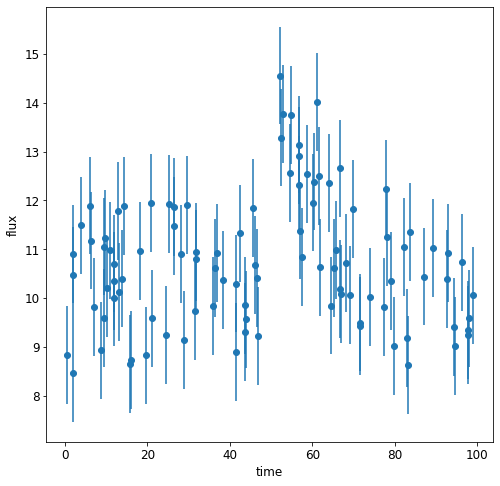

In [3]:
t,y,yerr=data.T
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

These are the old burst model and the new gaussian profile model:

In [4]:
def burst(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))


def gprofile(theta,t):
    A,b,t0,sigmaW=theta     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 ) / 2)


t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)



First, let's reproduce our previous results using dynesty

In [5]:
# Define the dimensionality of our problem.
ndim = 4

def loglike(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst':
        y_fit = burst(theta, x)
    elif model == 'gprofile':
        y_fit = gprofile(theta, x)

    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 


def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'burst'],ptform_args=['burst'],nlive=100)
sampler.run_nested()
sresults = sampler.results

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_916/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_916/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
383it [00:11, 10.03it/s, bound: 0 | nc: 31 | ncall: 3834 | eff(%):  9.990 | loglstar:   -inf < -173.903 <    inf | logz: -182.481 +/-  0.392 | dlogz: 114.672 >  0.109]    /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_916/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_916/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
453it [00:12, 76.73it/s, bound: 1 | nc: 5 | ncall: 3988 | eff(%): 11.359 | loglstar:   -inf < -115.147 <    inf | l

864it [00:20, 37.20it/s, bound: 14 | nc: 4 | ncall: 5876 | eff(%): 14.704 | loglstar:   -inf < -85.216 <    inf | logz: -93.460 +/-  0.348 | dlogz: 33.754 >  0.109]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_916/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1686it [00:31, 52.98it/s, +100 | bound: 32 | nc: 1 | ncall: 8727 | eff(%): 20.465 | loglstar:   -inf < -48.758 <    inf | logz: -63.270 +/-  0.515 | dlogz:  0.001 >  0.109]


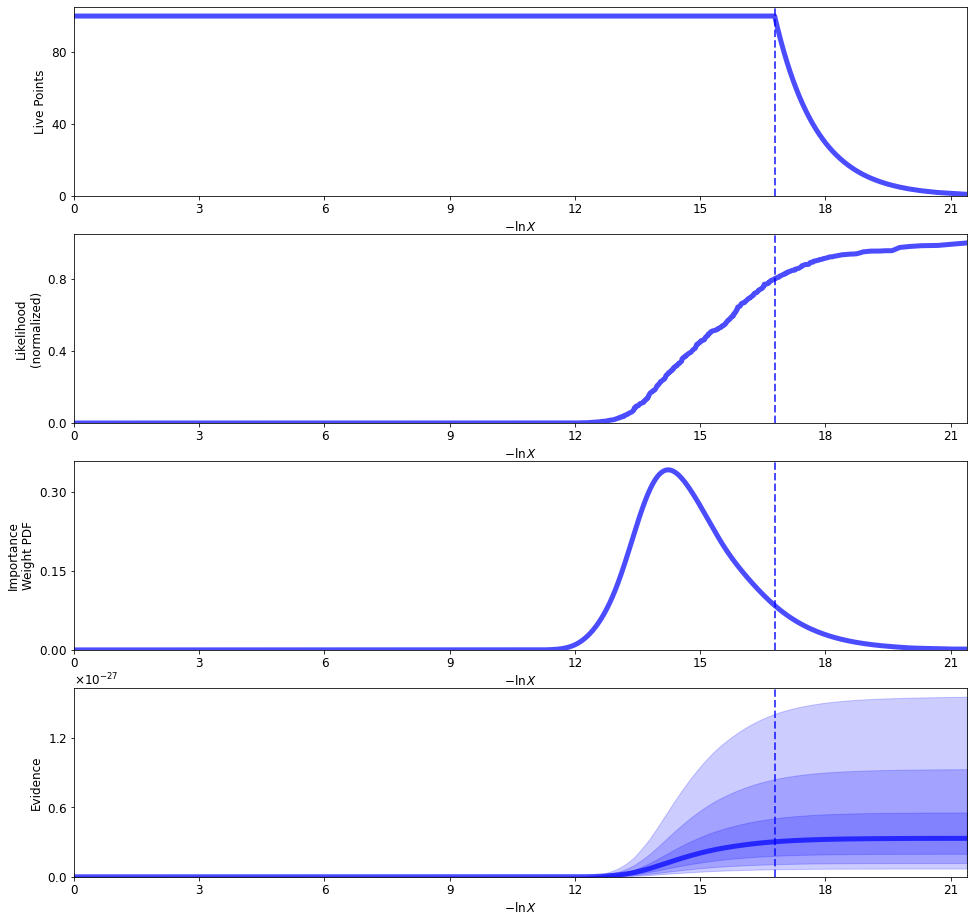

In [7]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

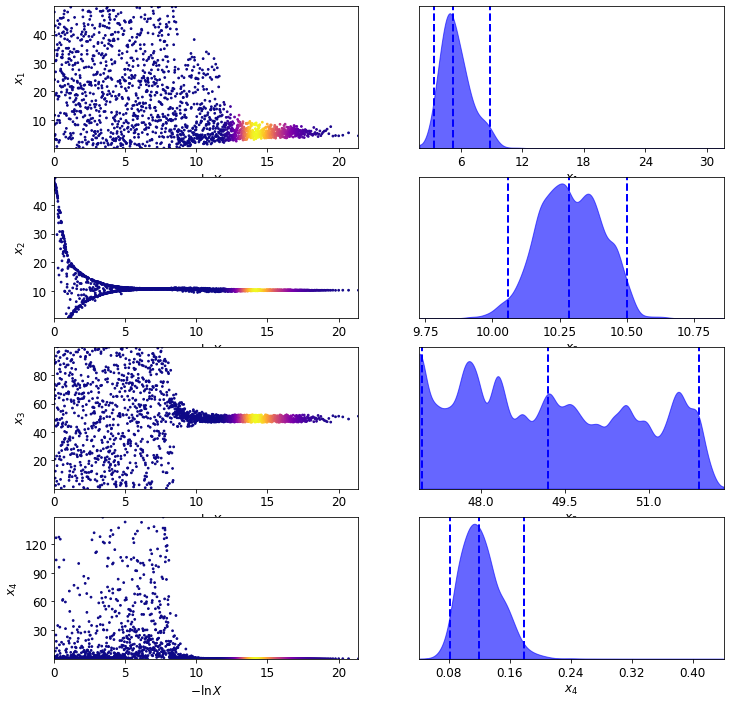

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

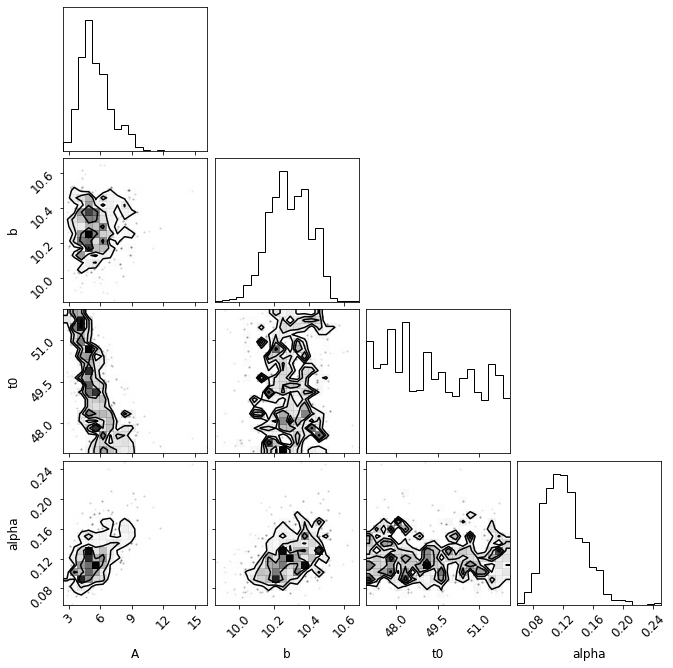

In [9]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [10]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))



A	=	5.25	+3.2	-1.63
b	=	10.29	+0.19	-0.19
t0	=	49.2	+2.58	-2.14
alpha	=	0.12	+0.05	-0.03


In [11]:
sresults.summary()

Summary
nlive: 100
niter: 1686
ncall: 8727
eff(%): 20.465
logz: -63.270 +/-  0.515


Ok now let's move on with the Gaussian profile:

In [12]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'gprofile'],ptform_args=['gprofile'],nlive=100)
sampler.run_nested()
sresults2 = sampler.results


1683it [00:30, 55.90it/s, +100 | bound: 38 | nc: 1 | ncall: 9227 | eff(%): 19.324 | loglstar:   -inf < -52.420 <    inf | logz: -66.917 +/-  0.506 | dlogz:  0.001 >  0.109]


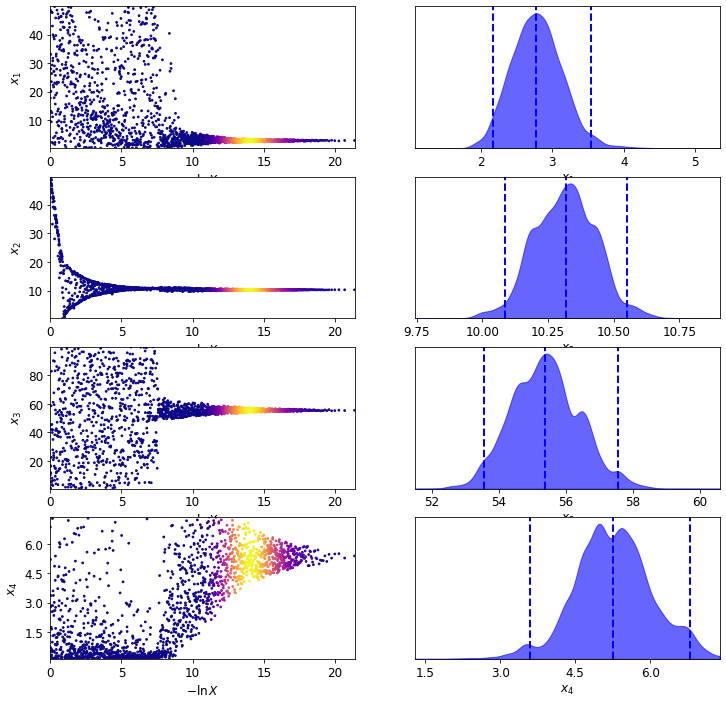

In [13]:
tfig, taxes = dyplot.traceplot(sresults2)

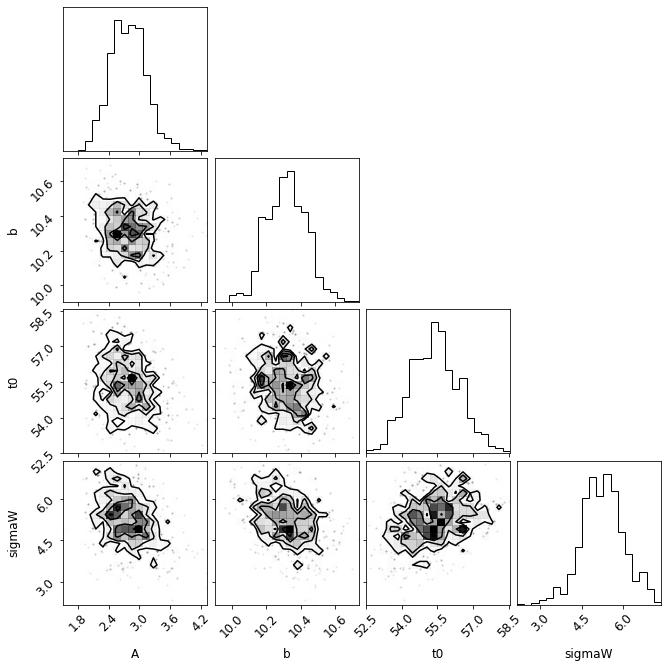

In [15]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

labels = ["A","b","t0","sigmaW"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [16]:
sresults2.summary()

Summary
nlive: 100
niter: 1683
ncall: 9227
eff(%): 19.324
logz: -66.917 +/-  0.506


Now compute the odds ratio (assuming equal hyperpriors) between the two models:

In [17]:
logevratio  = sresults.logz[-1]-sresults2.logz[-1]

print(logevratio/np.log(10), np.exp(logevratio))

1.5839831504399398 38.36923588816251


This is ["strong" evidence](https://en.wikipedia.org/wiki/Bayes_factor) in favour of the burst model

Text(0, 0.5, 'flux')

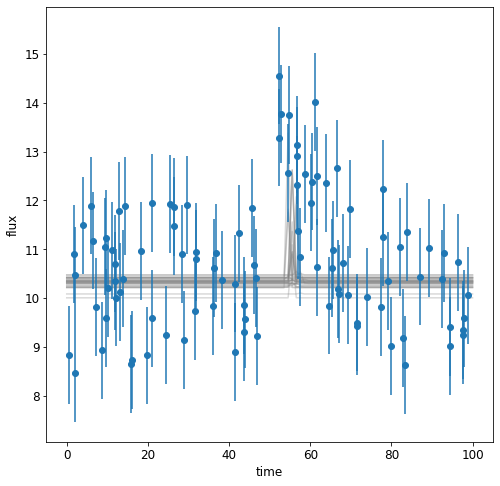

In [18]:
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=30)]

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")

Indeed, look how badly this is describing the data... Try to understand why

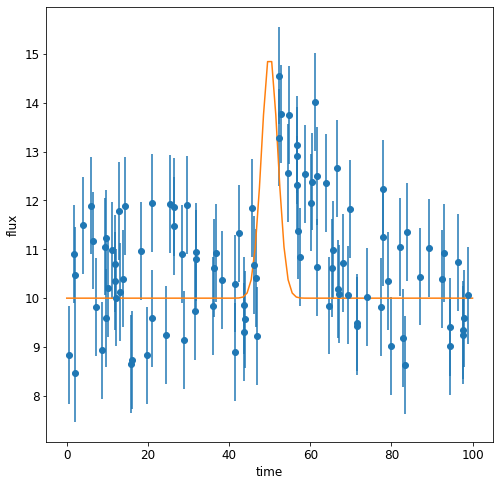

In [19]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
sigmaW_quick=2


theta_quick= np.array([A_quick,b_quick,t0_quick,sigmaW_quick])
ygrid =  gprofile(theta_quick,tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid)

Remember this does not tell you which model is correct, only that one is better than the other.